In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import matplotlib.colors as mcolors
import napari
import pandas as pd
from skimage.measure import label as skimage_label, regionprops_table
from laptrack import LapTrack
from laptrack import datasets
from laptrack.data_conversion import convert_split_merge_df_to_napari_graph
import os
from patchify import patchify  
import random
from scipy import ndimage
import datasets
from skimage.transform import resize
from skimage import exposure
from datasets import Dataset
from PIL import Image
from transformers import SamModel, SamConfig, SamProcessor
import torch
import cv2
from skimage import measure
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import os
from tqdm import tqdm
import time
import pickle

## Default SAM Model

In [3]:
## Load the model

# Define the path
checkpoint_path = os.path.join(os.getcwd(), "sam_vit_h_4b8939.pth")

# Initialize the model without loading the checkpoint
sam = sam_model_registry["default"](checkpoint=None)

# Load the state dictionary with weights_only=True
state_dict = torch.load(checkpoint_path, weights_only=True)

# Load the state dictionary into the model
sam.load_state_dict(state_dict)

<All keys matched successfully>

### Default SAM on test_data_7 

In [5]:
def process_slice(slice_2d, sam):
    # Convert Grayscale to RGB (if needed)
    if slice_2d.ndim == 2:
        slice_2d = np.stack((slice_2d,) * 3, axis=-1)  # Replicate the grayscale channel into 3 channels
    
    # Normalize and convert to uint8 if necessary
    if slice_2d.dtype == np.uint16:
        slice_2d = (slice_2d / 256).astype(np.uint8)  # Normalize and convert to uint8
    
    mask_generator = SamAutomaticMaskGenerator(sam)
    masks = mask_generator.generate(slice_2d)

    # Remove masks with an area greater than 20% of the total area
    total_area = slice_2d.shape[0] * slice_2d.shape[1] 
    masks = [mask for mask in masks if mask['area'] <= 0.2 * total_area]
    
    return masks

# Since SAM can efficiently process prompts, 
# masks for the WHOLE image can be generated by sampling a large number of prompts over an image.

# This function processes a 2D image slice, converts it into a format compatible with Segment Anything Model (SAM), 
# and generates segmentation masks using SAM's Automatic Mask Generator. 

In [6]:
# Define the relative path based on the current working directory
base_dir = os.path.join(os.getcwd(), "test_data_7", "intensity")

# Select an image to inspect
test_image_index = 1  # Change this to inspect another image
test_file_path = os.path.join(base_dir, f"intensity-{test_image_index:02d}.tif")

# Load the image and print its shape
image_3d = tifffile.imread(test_file_path)
print(f"Shape of intensity-{test_image_index:02d}.tif:", image_3d.shape)

Shape of intensity-01.tif: (41, 524, 568)


In [7]:
# Define the relative path based on the current working directory
base_dir = os.path.join(os.getcwd(), "test_data_7", "intensity")

# Dictionary to store masks for all slices
masks_PretrainedSAM_test_7_all = {}

# Loop through images from 1 to 7
for i in range(1, 8):
    masks_per_slice = []
    
    # Construct file path using robust relative path
    file_path = os.path.join(base_dir, f"intensity-{i:02d}.tif")
    
    # Read the 3D image file
    image_3d = tifffile.imread(file_path)
    
    # Use tqdm to track processing of slices within the image
    for j in tqdm(range(image_3d.shape[0]), desc=f"Processing Image {i}", unit="slice"):
        slice_2d = image_3d[j, :, :]
        masks = process_slice(slice_2d, sam)  # Assuming `process_slice` and `sam` are defined
        masks_per_slice.append(masks)
    
    # Store the masks for the current image
    masks_PretrainedSAM_test_7_all[i] = masks_per_slice

Processing Image 7: 100%|████████████████████| 55/55 [33:21<00:00, 36.39s/slice]


In [8]:
# Save the result 
output_file = os.path.join(os.getcwd(), "masks_PretrainedSAM_test_7_all.pkl")

# Save the dictionary as a .pkl file
with open(output_file, "wb") as f:
    pickle.dump(masks_PretrainedSAM_test_7_all, f)
print(f"Saved masks_PretrainedSAM_test_7_all successfully")

Saved masks_PretrainedSAM_test_7_all successfully


### Load the result

In [10]:
# Define the file path
pkl_file = os.path.join(os.getcwd(), "masks_PretrainedSAM_test_7_all.pkl")

# Load the dictionary from the .pkl file
with open(pkl_file, "rb") as f:
    masks_PretrainedSAM_test_7_all = pickle.load(f)

print("Loaded masks_PretrainedSAM_test_7_all successfully!")

Loaded masks_PretrainedSAM_test_7_all successfully!


### Visualization: Result of Pretraind SAM

In [12]:
# Define base directory (assuming you're in 'nuclei_seg_mouse')
base_dir = os.getcwd()  # Gets the current working directory

# Construct relative paths
image_path = os.path.join(base_dir, "test_data_7", "intensity", "intensity-01.tif")
label_path = os.path.join(base_dir, "test_data_7", "label", "intensity-01_3d_corr.tif")

# Read the 3D image and label files
image_3d = tifffile.imread(image_path)
label_3d = tifffile.imread(label_path)

# Select masks for the first image (assuming dictionary structure)
masks_per_slice = masks_PretrainedSAM_test_7_all[1]


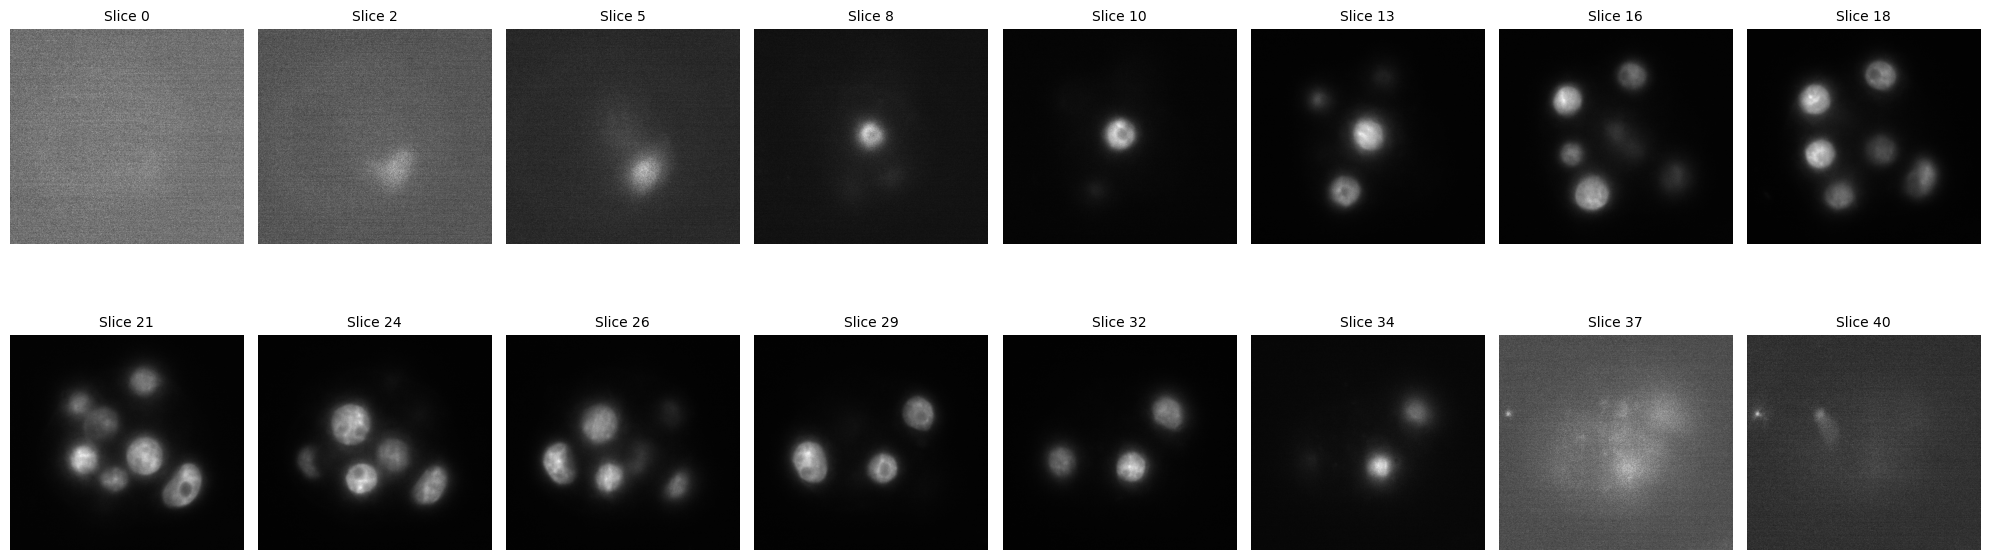

In [13]:
## Show some slices of the intensity image

# Select 16 evenly spaced slices
slices = np.linspace(0, image_3d.shape[0] - 1, 16, dtype=int)

# Create a figure with 2 rows and 8 columns (for 16 subplots)
fig, axes = plt.subplots(2, 8, figsize=(20, 7))

# Loop through selected slices
for i, ax in enumerate(axes.flat):
    ax.imshow(image_3d[slices[i]], cmap='gray')
    ax.set_title(f'Slice {slices[i]}', fontsize=10)
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [14]:
# Initialize a 3D mask array (same size as the intensity image)
masks_3d = np.zeros_like(image_3d, dtype=np.uint8) # store the segmented masks for each slice

# Create a list to store centroid coordinates along with their corresponding frame (slice index)
centroids_3d = []

# Loop through each 2D slice in the 3D intensity image
for i in range(image_3d.shape[0]):
    slice_2d = image_3d[i, :, :]  # Extract the current slice
    masks = masks_per_slice[i]  # Get segmentation masks for this slice

    # Create a blank 2D mask (same shape as the slice)
    combined_mask = np.zeros_like(slice_2d, dtype=np.uint8)

    # Process each mask within the slice
    for j, mask in enumerate(masks):
        # Assign unique label values to each segmented region in the mask
        combined_mask[mask['segmentation']] = j + 1  # Labels start from 1

    # Store the processed 2D mask into the 3D mask array
    masks_3d[i, :, :] = combined_mask

    # Label the connected regions in the mask
    labeled_mask = skimage_label(combined_mask)

    # Extract region properties (labels and centroids)
    properties = ['label', 'centroid']
    regionprops_data = regionprops_table(labeled_mask, properties=properties)
    regionprops_df = pd.DataFrame(regionprops_data)

    # Add a 'frame' column indicating which slice the centroids belong to
    regionprops_df['frame'] = i

    # Convert centroids into a structured list format: [frame, y, x]
    centroids_2d = np.column_stack((regionprops_df['centroid-0'], regionprops_df['centroid-1']))
    centroids_3d.extend([[i, y, x] for y, x in centroids_2d])

# Convert the collected centroids into a DataFrame for easier analysis
centroids_df = pd.DataFrame(centroids_3d, columns=['frame', 'centroid-0', 'centroid-1'])

# Display the DataFrame containing the centroids
centroids_df


,frame,centroid-0,centroid-1
0,8,260.831635,282.272926
1,9,259.079425,282.316718
2,11,259.358397,285.341288
3,11,395.056140,226.454791
4,12,260.558335,285.513832
...,...,...,...
58,30,312.050705,138.433825
59,30,325.013346,311.933026
60,31,193.989245,400.057782
61,31,323.367680,310.845941


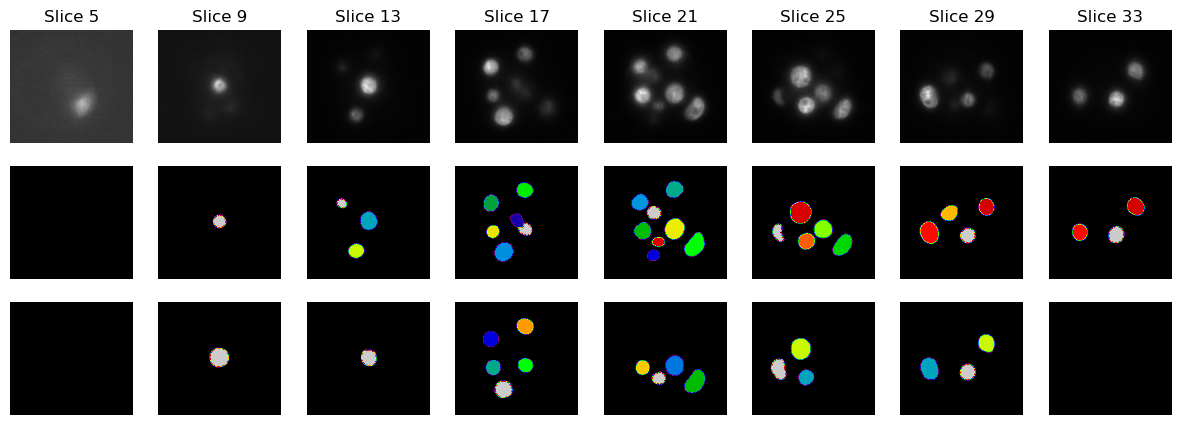

In [15]:
# Number of slices to display
num_slices = 8

# Create a figure with a 3x10 grid of subplots
fig, axes = plt.subplots(3, num_slices, figsize=(15, 5))

for i in range(num_slices):
    # Plot the ith slice of image_3d
    axes[0, i].imshow(image_3d[4*i+4], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Slice {4*i+5}')

    # Plot the ith slice of label_3d
    axes[1, i].imshow(label_3d[4*i+4], cmap='nipy_spectral')
    axes[1, i].axis('off')

    # Plot the ith slice of masks_3d
    axes[2, i].imshow(masks_3d[4*i+5], cmap='nipy_spectral')
    axes[2, i].axis('off')

    
plt.show()


Row 1: Original Intensity;   
Row 2: Manually Labelled Masks;   
Row 3: SAM Predicted Masks

### Do the tracking and form 3D segmentation in Pretrained SAM 

In [18]:
# Initialize LapTrack for 3D tracking
lt = LapTrack(track_cost_cutoff=10**2, splitting_cost_cutoff=False, merging_cost_cutoff=False)

# Predict tracks using LapTrack
track_df, split_df, merge_df = lt.predict_dataframe(
    centroids_df,
    coordinate_cols=['centroid-0', 'centroid-1'],
    only_coordinate_cols=False,
)

In [19]:
# Initialize the Napari viewer
viewer = napari.Viewer()

# Reset index of track_df to ensure proper indexing
track_df = track_df.reset_index(drop=True)

# Convert split and merge dataframes to Napari graph
graph = convert_split_merge_df_to_napari_graph(split_df, merge_df)

# Add the original 3D image
viewer.add_image(image_3d, name='3D Intensity Image', rendering='mip')

# Add the manually annotatod masks
viewer.add_image(label_3d, name='Manually Labelled Masks', rendering='mip')

# Add the 3D predicted masks
viewer.add_labels(masks_3d, name='SAM Predicted Masks')

## Showing clonal cells by the same colors 
# Prepare new labels array for 3D
clonal_cell_label = np.zeros_like(masks_3d)

# Assign new labels based on track_id
for i, row in track_df.iterrows():
    frame = int(row["frame_y"])
    y = int(row["centroid-0"])
    x = int(row["centroid-1"])
    label = masks_3d[frame, y, x]
    inds = masks_3d[frame] == label
    clonal_cell_label[frame][inds] = int(row["track_id"]) + 1

# Add the new labels to the viewer
viewer.add_labels(clonal_cell_label, name='Colored Clonal Cells')
viewer.layers['SAM Predicted Masks'].visible = False

# Visualize centroids as points in 3D
centroids_3d_array = np.array(centroids_3d)
viewer.add_points(centroids_3d_array, name='3D Centroids', size=10, face_color='red')

# Start the Napari event loop
napari.run()